# PROJECT 1, PART a)

The main aim of this project is to study in more detail various regression methods,
including the Ordinary Least Squares (OLS) method and Ridge regression. We will first study how to fit polynomials to a specific two-dimensional
function called Franke’s function. Our first step will be to perform
an OLS regression analysis of this function, trying out a polynomial fit with an x
and y dependence of the form [x, y, x2
, y2
, xy, . . . ] The Python code for the Franke function is included here (it performs also a
three-dimensional plot of it)

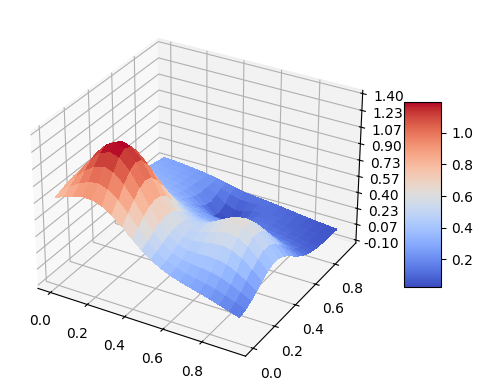

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


[-0.42309495 -0.43777345 -1.58447639  1.39693908  0.28834146  0.22731739
 -0.24713909 -0.42103909 -0.28779305  1.02386312 -0.59573759 -0.13634346
 -0.09692867  0.08655584 -0.08266717  0.16135367  0.22832384  0.0810168
 -0.03369526  0.02795902 -0.20663545]
Training R2
0.9048583140523787
Training MSE
0.09929275719502073
Test R2
0.7223462174465038
Test MSE
0.24437334196930516


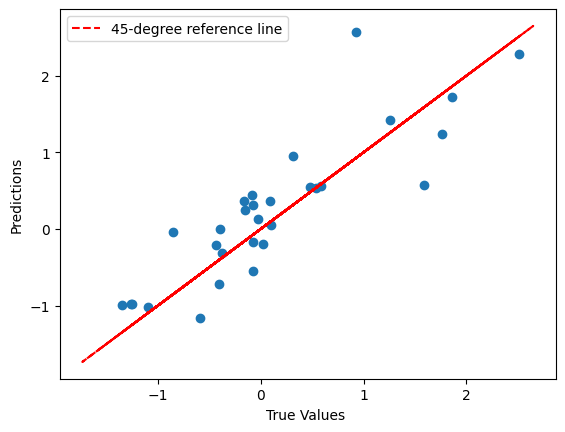

In [19]:
#code for OLS with Franke function using polynomials in x and y up to fifth order

#the first thing is to compute the design matrix. For that, let's calculate our independent variables from the values of x and y defined above. For that,
#we will use the functionality PolynomialFeatures with degree 5.

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

np.random.seed(42)

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

x=np.random.rand(100)
y = np.random.rand(100)
z = FrankeFunction(x,y) + 0.1*np.random.normal(0, 1, size=x.shape)
z_no_noise = FrankeFunction(x,y)

#lets normalize
x_normalized = (x - np.mean(x)) / np.std(x)
y_normalized = (y - np.mean(y)) / np.std(y)
z_normalized = (z - np.mean(z)) / np.std(z)

n = len(x)
degree = 5

# Create a PolynomialFeatures object
poly = PolynomialFeatures(degree=degree)

# Transform the input features to include polynomial terms
x_y_array = np.array(list(zip(x_normalized,y_normalized))) 
x_y_array_poly = poly.fit_transform(x_y_array)

#design matrix: just a reshape of the x_y_array_poly
design_mat_X = np.reshape(x_y_array_poly, (n,-1))

# We split the data in test and training data
X_train, X_test, z_train, z_test = train_test_split(design_mat_X, z_normalized, test_size=0.3) 

# Singular Value Decomposition (SVD) with the trained matrix
#U, S, Vt = np.linalg.svd(X_train, full_matrices=False)

# Calculation of optimal parameters
beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
print(beta)

ztilde = X_train @ beta
print("Training R2")
print(R2(z_train,ztilde))
print("Training MSE")
print(MSE(z_train,ztilde))
#now we make the prediction
zpredict = X_test @ beta
print("Test R2")
print(R2(z_test,zpredict))
print("Test MSE")
print(MSE(z_test,zpredict))

plt.scatter(z_test, zpredict )

plt.plot(z_normalized, z_normalized, color='red', linestyle='--', label='45-degree reference line')
plt.xlabel('True Values ')
plt.ylabel('Predictions')
plt.legend()
plt.show()



In [5]:
from scipy import stats
from scipy.stats import t
#we need to calculate the confidence intervals for our beta parameters by computing their variance. We will do this by computing only their standard errors, which are just the square roots of the variance
#The covariance matrix of the estimated coefficients is given by: covar(beta) = sigma^2(X^(T)·X)^(-1) and the standard error is the sqrt of the diagonal elements

# Confidence Intervals
alpha = 0.05  # Set the confidence level to 95%
t_critical = stats.t.ppf(1 - alpha / 2, df=n - len(beta))  #df are de degrees of freedom and ppf returns the value at which the cumulative distribution function (in this case of a t distribution) reaches a specified probability.
                        # t-distribution critical value: critical t-value
                        #accounts for the variability in the estimate due to the sample size and provides a 
                        #measure of uncertainty associated with the parameter estimate. The larger the sample size, the closer the t-distribution approaches the standard normal distribution

# Standard errors of the estimators
se_beta = np.sqrt(np.diag(MSE(z_test, zpredict) * np.linalg.inv(design_mat_X.T @ design_mat_X))) #np.linalg.inv(design_mat_X.T @ design_mat_X)): covariance matrix


# Calculate margin of error
margin_of_error = t_critical * se_beta

# Calculate confidence intervals for each coefficient
ci_lower = beta - margin_of_error
ci_upper = beta + margin_of_error

# Display results
for i, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
    print(f"Confidence Interval for beta_{i}: [{lower}, {upper}]") 

Confidence Interval for beta_0: [-0.20090715718742727, 0.26177376735352986]
Confidence Interval for beta_1: [-1.0941638581059618, -0.12196109307447484]
Confidence Interval for beta_2: [-1.8679355002450837, -0.8878103538485532]
Confidence Interval for beta_3: [-0.024831692547414963, 0.6895033146382064]
Confidence Interval for beta_4: [0.499908553018925, 1.2029875766648819]
Confidence Interval for beta_5: [-0.619704500694158, 0.1773219037032261]
Confidence Interval for beta_6: [-0.43369031902842514, 0.4815623243717234]
Confidence Interval for beta_7: [-0.7310388601821737, 0.22968592134492816]
Confidence Interval for beta_8: [-1.0296360655918066, 0.2296477680003598]
Confidence Interval for beta_9: [-0.08071881924623969, 1.0529618403704593]
Confidence Interval for beta_10: [-0.3043164113714503, -0.06138334514653804]
Confidence Interval for beta_11: [-0.3837434304603436, -0.14101122487568435]
Confidence Interval for beta_12: [0.08495155572735305, 0.395379450839889]
Confidence Interval for b

# PROJECT 1, PART B)

Before you perform an analysis of the bias-variance trade-off on your test
data, make first a figure similar to Fig. 2.11 of Hastie, Tibshirani, and Friedman.
Figure 2.11 of this reference displays only the test and training MSEs. The test
MSE can be used to indicate possible regions of low/high bias and variance.

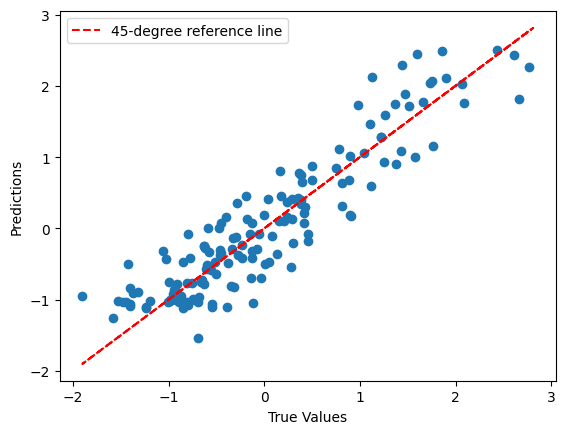

Error: 0.17511449483108513
Bias^2: 0.16601288453269214
Var: 0.009101610298392942
0.17511449483108513 >= 0.16601288453269214 + 0.009101610298392942 = 0.17511449483108507


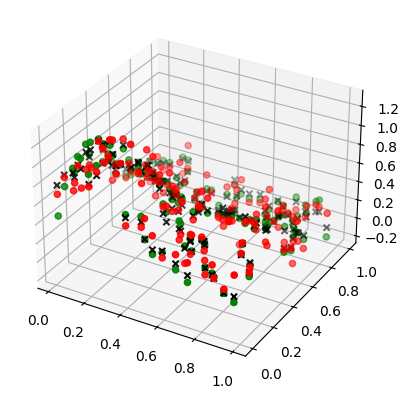

In [6]:
#Let's modified the above code to introduce bootstrap resampling technique

#the first thing is to compute the design matrix. For that, let's calculate our independent variables from the values of x and y defined above. For that,
#we will use the functionality PolynomialFeatures with degree 5.

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import math
from mpl_toolkits.mplot3d import Axes3D


np.random.seed(41)

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

x=np.random.rand(500)
y = np.random.rand(500)
z = FrankeFunction(x,y) + 0.1*np.random.normal(0, 1, size=x.shape)
z_no_noise = FrankeFunction(x,y)

#lets normalize
x_normalized = (x-np.mean(x))/np.std(x)
y_normalized = (y-np.mean(y))/np.std(y)
z_normalized = (z-np.mean(z))/np.std(z)

n = len(x)
deg = 5

# Create a PolynomialFeatures object
poly = PolynomialFeatures(degree=deg)


# Transform the input features to include polynomial terms
x_y_array = np.array(list(zip(x_normalized,y_normalized)))
x_y_array_train, x_y_array_test, z_train, z_test = train_test_split(x_y_array, z_normalized, test_size = 0.3)

x_y_array_poly = poly.fit_transform(x_y_array_train)
x_y_array_poly2 = poly.fit_transform(x_y_array_test)

#design matrix: just a reshape of the x_y_array_poly
X_train = np.reshape(x_y_array_poly, (len(x_y_array_train),-1))
X_test = np.reshape(x_y_array_poly2, (len(x_y_array_test),-1))

#bootstrap variables
n_bootstrap = 100
bootstrap_coefs = []
bootstrap_mse = []
zpredict_boot = np.zeros((len(z_test), n_bootstrap))

for m in range(n_bootstrap):

    X_boot, z_boot = resample(X_train, z_train, replace = True)

    # Calculation of optimal parameters
    beta = np.linalg.inv(X_boot.T.dot(X_boot)).dot(X_boot.T).dot(z_boot)
    zpredict_boot[:,m] = X_test @ beta


plt.scatter(z_test, np.mean(zpredict_boot, axis=1) )

plt.plot(z_normalized, z_normalized, color='red', linestyle='--', label='45-degree reference line')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

#calculation of error, bias and variance
z_test = np.reshape(z_test,(len(z_test),1))
error = np.mean( np.mean((z_test - zpredict_boot)**2, axis=1, keepdims=True) )
bias = np.mean( (z_test - np.mean(zpredict_boot, axis=1, keepdims=True))**2 )
variance = np.mean( np.var(zpredict_boot, axis=1, keepdims=True) )
print('Error:', error)
print('Bias^2:', bias)
print('Var:', variance)
print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))


#interesting plots

# Unzip the list of tuples
unzipped = np.array(list(zip(*(x_y_array_test))))

# Resulting lists
first_elements, second_elements = unzipped
first_elements = np.array(first_elements)
second_elements=np.array(second_elements)

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')

#return everything to the initial scale for the plot

f = first_elements*np.std(x)+np.mean(x)
s = second_elements*np.std(y)+np.mean(y)

ax.scatter(f, s,  FrankeFunction(f,s), c='black', marker='x')
ax.scatter(f, s, z_test*np.std(z)+np.mean(z), c='r', marker='o')
ax.scatter(f, s, np.mean(zpredict_boot, axis=1)*np.std(z)+np.mean(z), c='g', marker='o')

plt.show()



Perform then a bias-variance analysis of the Franke function by studying
the MSE value as function of the complexity of your model. Plot the bias and
variance trade-off, and evaluate how it depends on your model complexity, the
number of data points, and possibly also the noise parameter.


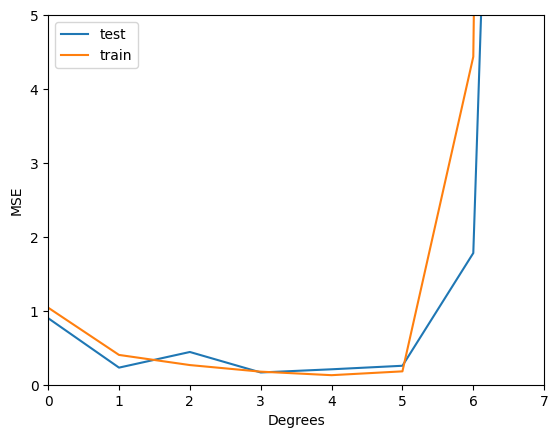

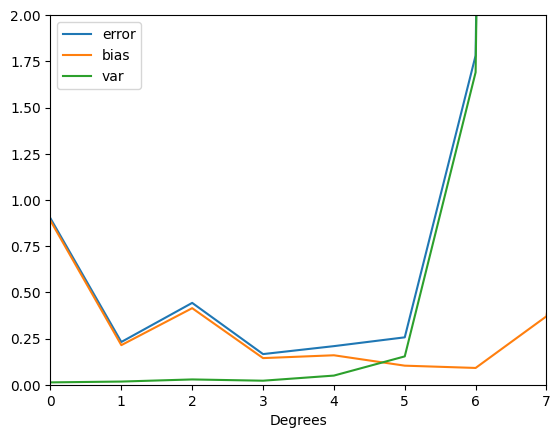

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

np.random.seed(41)

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

x=np.random.rand(100)
y = np.random.rand(100)
z = FrankeFunction(x,y) + 0.1*np.random.normal(0, 1, size=x.shape)
z_no_noise = FrankeFunction(x,y)

#lists for MSE and degree
degrees = np.arange(10)
MSE_list_train = []
MSE_list_test = []
Bias_list=[]
variance_list=[]

#lets normalize
x_normalized = (x - np.mean(x)) / np.std(x)
y_normalized = (y - np.mean(y)) / np.std(y)
z_normalized = (z - np.mean(z)) / np.std(z)

n = len(x)
x_y_array = np.array(list(zip(x_normalized,y_normalized))) 

for degree in degrees:

    # Create a PolynomialFeatures object
    poly = PolynomialFeatures(degree=degree)

    # Transform the input features to include polynomial terms

    x_y_array_poly = poly.fit_transform(x_y_array)

    #design matrix: just a reshape of the x_y_array_poly
    design_mat_X = np.reshape(x_y_array_poly, (n,-1))

    # We split the data in test and training data
    X_train, X_test, z_train, z_test = train_test_split(design_mat_X, z_normalized, test_size=0.2) 

    #bootstrap variables
    n_bootstrap = 100
    bootstrap_coefs = []
    bootstrap_mse = []
    zpredict_boot = np.zeros((len(z_test), n_bootstrap))
    ztilde_boot = np.zeros((len(z_train), n_bootstrap))

    for m in range(n_bootstrap):

        X_boot, z_boot = resample(X_train, z_train, replace = True)

        # Calculation of optimal parameters
        beta = np.linalg.inv(X_boot.T.dot(X_boot)).dot(X_boot.T).dot(z_boot)
        zpredict_boot[:,m] = X_test @ beta
        ztilde_boot[:,m]  = X_train @ beta
    
    #reshaping for broadcasting
    z_test = np.reshape(z_test,(len(z_test),1))
    z_train = np.reshape(z_train,(len(z_train),1))
       
    MSE_list_test.append(np.mean( np.mean((z_test - zpredict_boot)**2, axis=1, keepdims=True) ))
    MSE_list_train.append(np.mean( np.mean((z_train - ztilde_boot)**2, axis=1, keepdims=True) ))
    Bias_list.append( np.mean( (z_test - np.mean(zpredict_boot, axis=1, keepdims=True))**2 ))
    variance_list.append( np.mean( np.var(zpredict_boot, axis=1, keepdims=True) ))
    
plt.plot(degrees, MSE_list_test, label="test")
plt.plot(degrees, MSE_list_train, label = "train")
plt.ylim(0,5)
plt.xlim(0,7)
plt.xlabel('Degrees')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.plot(degrees, MSE_list_test, label="error")
plt.plot(degrees, Bias_list, label = "bias")
plt.plot(degrees, variance_list, label = "var")
plt.ylim(0,2)
plt.xlim(0,7)
plt.xlabel('Degrees')
plt.legend()
plt.show()

# PROJECT 1, PART c)
Implement the k-fold cross-validation algorithm and evaluate again the MSE
function resulting from the test folds. You can use the functionality of ScikitLearn or even write your own code. Try 5 − 10 folds, comment on your results.

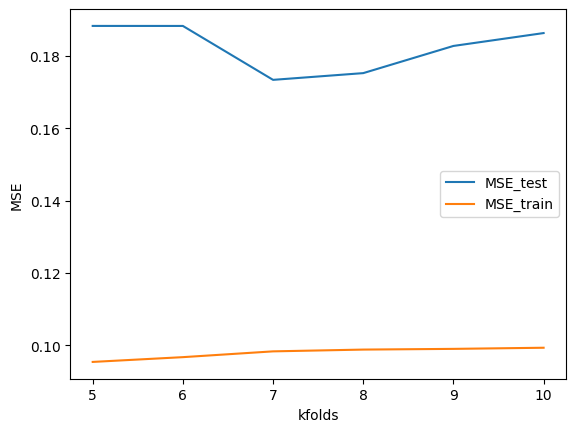

In [9]:
#evaluation of the MSE as a function of the number of foldswith the optimal polinomial degree from above: 1

from sklearn.model_selection import cross_val_predict, KFold
#cross_val_predict already does the splitting of the data into training and test internally, so there is no need to do this explicitly on the code
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt

x=np.random.rand(100)
y = np.random.rand(100)
z = FrankeFunction(x,y) + 0.1*np.random.normal(0, 1, size=x.shape)
z_no_noise = FrankeFunction(x,y)

#lists for MSE and degree
k_folds = np.arange(5,11)
MSE_list_train = []
MSE_list_test = []

#lets normalize
x_normalized = (x - np.mean(x)) / np.std(x)
y_normalized = (y - np.mean(y)) / np.std(y)
z_normalized = (z-np.mean(z))/ np.std(z)

x_y_array = np.array(list(zip(x_normalized,y_normalized))) 
n = len(x)

z_predict_fold = np.zeros(n)

poly = PolynomialFeatures(degree=5)
x_y_array_poly = poly.fit_transform(x_y_array)
design_mat_X = np.reshape(x_y_array_poly, (n, -1))
model = LinearRegression()

for k in k_folds:

    # Use k-fold cross-validation with the specified number of folds (k_fold)
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    mse_train = 0
    mse_test = 0

    #we want to know which data has been used for testing and which for training to calculate separate mse
    for train_ind, test_ind in kfold.split(design_mat_X): 
        X_train, X_test = design_mat_X[train_ind], design_mat_X[test_ind]
        z_train, z_test = z_normalized[train_ind], z_normalized[test_ind]

        #fit the model
        model.fit(X_train, z_train)

        ztilde = model.predict(X_train)
        zpredict = model.predict(X_test)

        mse_train = mse_train+ MSE(z_train, ztilde)
        mse_test = mse_test+MSE(z_test, zpredict)

    #now we need to average over all kfolds
    mse_train = mse_train/k
    mse_test = mse_test / k
    MSE_list_train.append(mse_train)
    MSE_list_test.append(mse_test)

    # Plotting the predicted values for each degree in the current k-fold
    #plt.figure()
    #plt.scatter(z_normalized, z_predict_fold, label=f'Degree {5}')
    #plt.plot(z_normalized, z_normalized, color='red', linestyle='--', label='45-degree reference line')


plt.plot(k_folds, MSE_list_test, label="MSE_test")
plt.plot(k_folds, MSE_list_train, label="MSE_train")
plt.xlabel('kfolds')
plt.ylabel("MSE")
plt.legend()
plt.show()


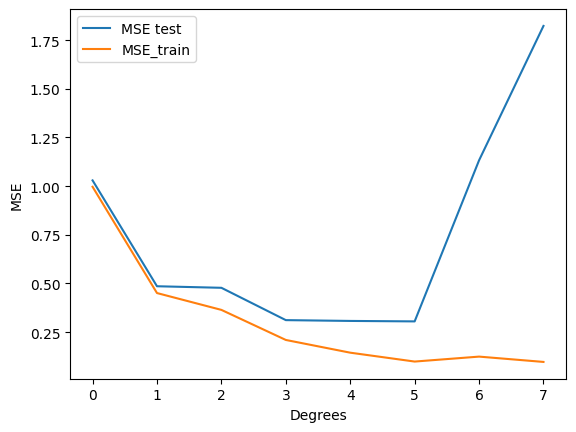

In [10]:
#now as we see that the mse doesn't change that much with k, we set K = 5
from sklearn.model_selection import cross_val_predict, KFold
#cross_val_predict already does the splitting of the data into training and test internally, so there is no need to do this explicitly on the code
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt

x=np.random.rand(100)
y = np.random.rand(100)
z = FrankeFunction(x,y) + 0.1*np.random.normal(0, 1, size=x.shape)
z_no_noise = FrankeFunction(x,y)

#lists for MSE and degree
k_fold = 5
degrees = np.arange(8)
MSE_list_train = []
MSE_list_test = []

#lets normalize
x_normalized = (x - np.mean(x)) / np.std(x)
y_normalized = (y - np.mean(y)) / np.std(y)
z_normalized = (z-np.mean(z))/ np.std(z)

x_y_array = np.array(list(zip(x_normalized,y_normalized))) 
n = len(x)

z_predict_fold = np.zeros(n)

# Use k-fold cross-validation with the specified number of folds (k_fold)
kfold = KFold(n_splits=k_fold, shuffle=True, random_state=42)

for deg in degrees:

    poly = PolynomialFeatures(degree=deg)
    x_y_array_poly = poly.fit_transform(x_y_array)
    design_mat_X = np.reshape(x_y_array_poly, (n, -1))
    model = LinearRegression()

    mse_train = 0
    mse_test = 0

    #we want to know which data has been used for testing and which for training to calculate separate mse
    for train_ind, test_ind in kfold.split(design_mat_X): 
        X_train, X_test = design_mat_X[train_ind], design_mat_X[test_ind]
        z_train, z_test = z_normalized[train_ind], z_normalized[test_ind]

        #fit the model
        model.fit(X_train, z_train)

        ztilde = model.predict(X_train)
        zpredict = model.predict(X_test)

        mse_train = mse_train+ MSE(z_train, ztilde)
        mse_test = mse_test+MSE(z_test, zpredict)

    #now we need to average over all kfolds
    mse_train = mse_train/k_fold
    mse_test = mse_test / k_fold
    MSE_list_train.append(mse_train)
    MSE_list_test.append(mse_test)
    
plt.plot(degrees, MSE_list_test, label="MSE test")
plt.plot(degrees, MSE_list_train, label = "MSE_train")
plt.xlabel('Degrees')
plt.ylabel("MSE")
plt.legend()
plt.show()

#this has to be done for polynomials not for the kfold

# PROJECT 1, PART d)
Perform the same bootstrap analysis as in the
part b)  (for the same polynomials) and the cross-validation part in part c) but now for different values of $\lambda$. 

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


# Generate random x and y values
np.random.seed(42)  # for reproducibility
n_samples = 1000
x = np.random.rand(n_samples)
y = np.random.rand(n_samples)
# Step 1: Generate Franke function data
z = FrankeFunction(x, y)

# Reshape x and y to 2D arrays
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Step 2: Split data into training and testing sets
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

# Step 3: Define range of lambda values
lambda_values = [0.1, 1, 10, 100, 1000]
mse_list=[]
# Step 4: Implement Ridge Regression
for l in lambda_values:
    ridge_model = Ridge(alpha=l)

    # Step 5: Perform resampling techniques for each lambda value
    # Bootstrap analysis
    # Your code for bootstrap analysis here

    # Cross-validation
    # Your code for cross-validation here

    # Step 6: Evaluate model performance
    ridge_model.fit(x_train, z_train)  # Use x_train and z_train
    z_pred = ridge_model.predict(x_test)  # Use x_test for prediction
    mse = mean_squared_error(z_test, z_pred)
    mse_list.append(mse)
    print(f"Lambda: {l}, MSE: {mse}")

Lambda: 0.1, MSE: 0.0530332962148643
Lambda: 1, MSE: 0.052997582926065545
Lambda: 10, MSE: 0.0530187482634965
Lambda: 100, MSE: 0.059356085288435896
Lambda: 1000, MSE: 0.07031129801212259


Compare and
analyze your results with those obtained in parts a-c). Study the
dependence on $\lambda$.

Lambda: 0.1, MSE: 0.0530332962148643
Lambda: 1, MSE: 0.052997582926065545
Lambda: 10, MSE: 0.0530187482634965
Lambda: 100, MSE: 0.059356085288435896
Lambda: 1000, MSE: 0.07031129801212259


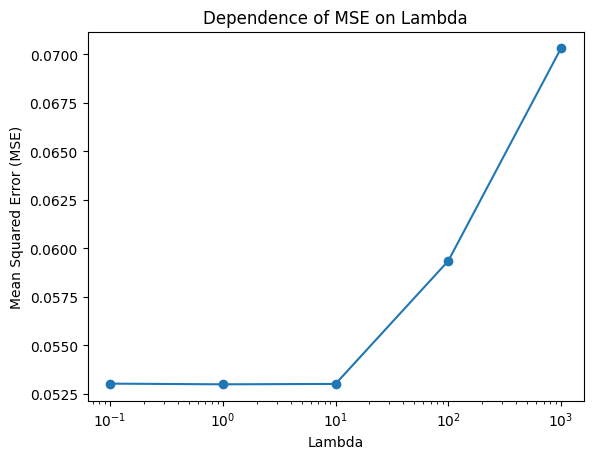

In [12]:
import matplotlib.pyplot as plt

# List to store MSE values for different lambda values
mse_values = []

# Step 4: Implement Ridge Regression
for l in lambda_values:
    ridge_model = Ridge(alpha=l)

    # Step 5: Perform resampling techniques for each lambda value
    # Bootstrap analysis
    # Your code for bootstrap analysis here

    # Cross-validation
    # Your code for cross-validation here

    # Step 6: Evaluate model performance
    ridge_model.fit(x_train, z_train)  # Use x_train and z_train
    z_pred = ridge_model.predict(x_test)  # Use x_test for prediction
    mse = mean_squared_error(z_test, z_pred)
    mse_values.append(mse)  # Store MSE value for this lambda

    # Print MSE for this lambda
    print(f"Lambda: {l}, MSE: {mse}")

# Plot the dependence of MSE on lambda
plt.plot(lambda_values, mse_values, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Dependence of MSE on Lambda')
plt.xscale('log')  # Use log scale for better visualization if lambda varies widely
plt.grid(False)
plt.show()


Study also the bias-variance trade-off as function of various values of
the parameter $\lambda$. For the bias-variance trade-off, use the **bootstrap** resampling method. Comment your results.

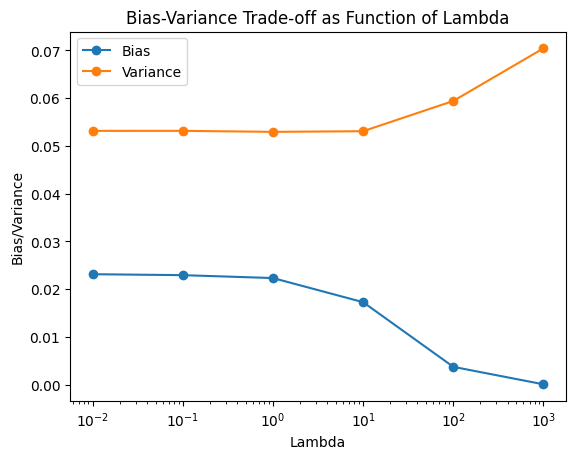

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Define a function to calculate bias and variance
def calculate_bias_variance(predictions, true_values):
    bias = np.mean((predictions - np.mean(predictions)) ** 2)
    variance = np.mean((predictions - true_values) ** 2)
    return bias, variance

# Step 3: Define range of lambda values
lambda_values = [0.01, 0.1, 1, 10, 100, 1000]

# Lists to store bias and variance values for each lambda
bias_values = []
variance_values = []

# Step 4: Implement Ridge Regression
for l in lambda_values:
    # List to store predictions for each bootstrap sample
    predictions = []
    
    for _ in range(100):  # Perform bootstrap resampling 100 times
        # Bootstrap resampling
        x_boot, z_boot = resample(x_train, z_train)
        
        # Fit Ridge Regression model
        ridge_model = Ridge(alpha=l)
        ridge_model.fit(x_boot, z_boot)
        
        # Predict on test set
        z_pred = ridge_model.predict(x_test)
        predictions.append(z_pred)

    # Calculate bias and variance for this lambda value
    bias, variance = calculate_bias_variance(np.mean(predictions, axis=0), z_test)
    bias_values.append(bias)
    variance_values.append(variance)

# Step 5: Plot bias and variance as functions of lambda
plt.plot(lambda_values, bias_values,'o-', label='Bias')
plt.plot(lambda_values, variance_values,'o-', label='Variance')
plt.xlabel('Lambda')
plt.ylabel('Bias/Variance')
plt.title('Bias-Variance Trade-off as Function of Lambda')
plt.xscale('log')  # Use log scale for better visualization if lambda varies widely
plt.legend()
plt.grid(False)
plt.show()

# Step 6: Analyze results and comment
# Your comments on bias-variance trade-off here
